In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("./"), '..')))

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.fft import fft, ifft
import plot_settings as plot_settings
from scipy.signal import butter, sosfiltfilt

In [3]:
# Caricamento dei dati
data_file = "dati H1 32s progetto 3.txt"
template_file = "template.txt"

# Dati interferometro
data = np.loadtxt(data_file)
# Template dell'onda gravitazionale
template = np.loadtxt(template_file)
time = data[:, 0]  # Colonna del tempo (GPS)
strain = data[:, 1]  # Colonna del segnale (strain)

# Campionamento
dt = time[1] - time[0]  # Intervallo temporale
fs = 1 / dt  # Frequenza di campionamento
T = len(time) * dt  # Durata del segnale
df = 1 / T  # Risoluzione in frequenza

template_length = len(template)


In [4]:
duration = time[-1] - time[0]  # Durata del segnale
duration

31.999755859375

In [5]:
len(strain)

131072

(array([[1.66116596e-38, 2.26451044e-39, 1.39666056e-38, ...,
         1.38159171e-38, 1.48879469e-38, 1.17120485e-38],
        [1.17607913e-38, 6.80728336e-39, 9.56715350e-39, ...,
         1.18977827e-38, 1.34649220e-38, 1.35212061e-38],
        [1.96076800e-40, 1.72529790e-40, 1.35648885e-40, ...,
         1.56558700e-40, 2.27843386e-40, 3.04516096e-40],
        ...,
        [2.85864258e-45, 1.55016309e-44, 1.96578981e-45, ...,
         9.82895897e-45, 1.20242479e-44, 1.72352326e-44],
        [2.86742333e-45, 1.55233766e-44, 1.97436742e-45, ...,
         9.82665839e-45, 1.19513396e-44, 1.71696849e-44],
        [1.40495358e-45, 7.72304442e-45, 9.81707570e-46, ...,
         4.90030443e-45, 5.99847747e-45, 8.61376922e-45]]),
 array([   0.,   16.,   32.,   48.,   64.,   80.,   96.,  112.,  128.,
         144.,  160.,  176.,  192.,  208.,  224.,  240.,  256.,  272.,
         288.,  304.,  320.,  336.,  352.,  368.,  384.,  400.,  416.,
         432.,  448.,  464.,  480.,  496.,  512.,  5

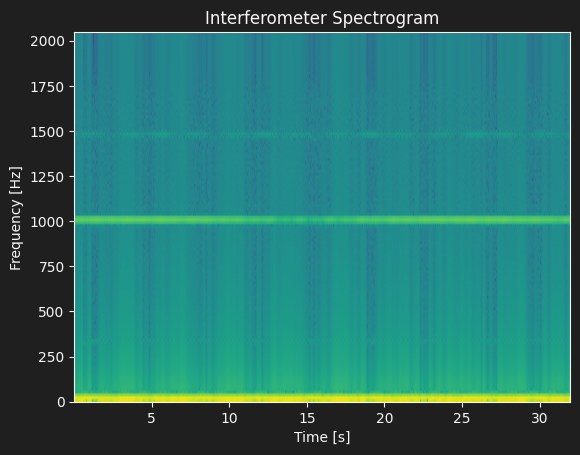

In [24]:
plot_settings.figure()
plot_settings.subplot(1,1,1,ylabel="Frequency [Hz]", xlabel="Time [s]")
plot_settings.title("Interferometer Spectrogram")
plt.specgram(strain, Fs= int(fs), NFFT=256, window=np.hamming(256))

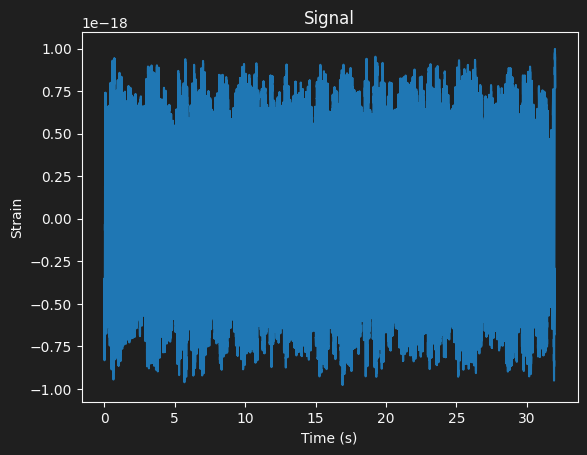

In [21]:

plot_settings.figure()
plot_settings.subplot(1,1,1,"Time (s)","Strain")
plot_settings.title("Signal")

plt.plot((time-time[0]), strain, label="Strain")

In [8]:
# Stima del Power Spectral Density (PSD) usando Welch
frequencies, psd = welch(strain, fs=fs, nperseg=fs//2)
psd_interp = np.interp(np.fft.fftfreq(len(strain), d=dt), frequencies, psd)

# Stima del Power Spectral Density (PSD) usando Welch
frequencies_temp, psd_temp = welch(template, fs=fs, nperseg=fs//2)


In [9]:
# FFT del segnale e del template

fft_template = dt * fft(template)
fft_template_conjugate = fft_template.conjugate()

In [10]:
imfr = np.argmax(fft_template[:template_length // 2])
my_frequencies = np.fft.fftfreq(template_length, d=dt)
my_frequencies[:template_length // 2][imfr]

7.5625

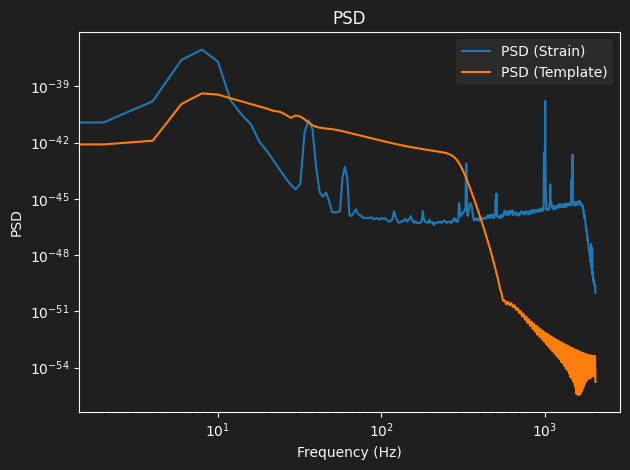

In [25]:

plot_settings.figure()
plot_settings.subplot(1,1,1,"Frequency (Hz)","PSD")
plot_settings.title("PSD")

plt.loglog(frequencies, psd, label="PSD (Strain)")
plt.loglog(frequencies_temp, psd_temp, label="PSD (Template)")

plot_settings.legend()
plt.tight_layout()
plt.show()

In [12]:
lowcut = 20
highcut = 300
order = 4

sos = butter(order, [lowcut, highcut], btype='bandpass', fs=fs, output='sos')
# Applica il filtro
filtered_signal = sosfiltfilt(sos, strain)
filtered_template = sosfiltfilt(sos, template)

In [13]:
fft_signal = dt * fft(filtered_signal)

In [14]:
frequencies_filtered, psd_filtered = welch(filtered_signal, fs=fs, nperseg=fs//2)
frequencies_filt_temp, psd_filt_temp = welch(filtered_template, fs=fs, nperseg=fs//2)

[]

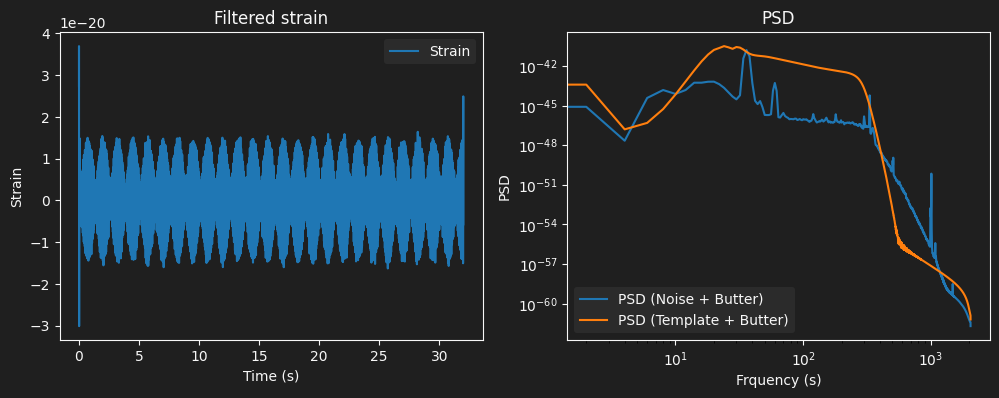

In [26]:
plot_settings.figure(figsize=(12, 4))
plot_settings.subplot(1, 2, 1,"Time (s)", "Strain")
plot_settings.title("Filtered strain")
plt.plot(time-time[0], filtered_signal, label="Strain")
plot_settings.legend()

plot_settings.subplot(1, 2, 2,"Frquency (s)", "PSD")
plot_settings.title("PSD")
plt.loglog(frequencies_filtered, psd_filtered, label="PSD (Noise + Butter)")
plt.loglog(frequencies_filt_temp, psd_filt_temp, label="PSD (Template + Butter)")
plot_settings.legend()

plt.plot()

In [16]:




integrand_norm = np.divide(fft_template*fft_template_conjugate, psd_interp)

norm = sum(np.real(integrand_norm))
norm = norm*df

template_fft_normalized = np.divide(fft_template,np.sqrt(norm))
template_fft_conjugate_normalized = np.divide(fft_template_conjugate,np.sqrt(norm))

integrand_norm2 = np.divide(template_fft_normalized*template_fft_conjugate_normalized,(psd_interp))

integrand = np.divide(fft_signal*template_fft_conjugate_normalized,psd_interp)

# Applicazione del filtro adattato nel dominio della frequenza
snr_time_domain = np.abs(ifft(integrand)/dt)

# Identificazione del picco di SNR
peak_snr_idx = np.argmax(snr_time_domain)
peak_time = time[peak_snr_idx]
peak_snr_value = snr_time_domain[peak_snr_idx]

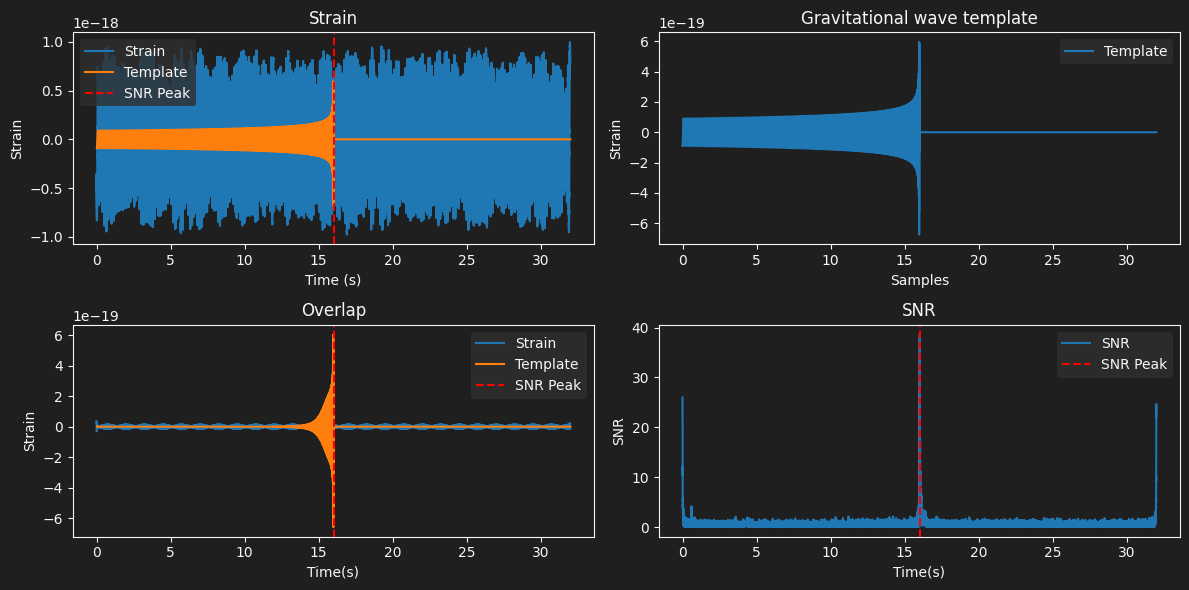

(1167559936.0180664, 38.609936079302166)

In [29]:

half_template = len(template) // 2
offset = peak_snr_idx - half_template

# Risultati e visualizzazione
plot_settings.figure(figsize=(12, 6))

# Segnale e template nel dominio del tempo
plot_settings.subplot(2, 2, 1,"Time (s)", "Strain")
plot_settings.title("Strain")
plt.plot((time-time[0]), strain, label="Strain")
plt.plot((time-time[0]) + offset*dt,template, label="Template")
plt.axvline(peak_time-time[0], color='r', linestyle='--', label="SNR Peak")
plot_settings.legend()

plot_settings.subplot(2, 2, 2,"Samples", "Strain")
plot_settings.title("Gravitational wave template")
plt.plot(np.linspace(0,len(template)*dt,len(template)),template, label="Template")
plot_settings.legend()

# PSD del rumore
plot_settings.subplot(2, 2, 3,"Time(s)", "Strain")
plot_settings.title("Overlap")
plt.plot(time-time[0], filtered_signal, label="Strain")
plt.plot((time-time[0]) + offset*dt,filtered_template, label="Template")
plt.axvline(peak_time-time[0], color='r', linestyle='--', label="SNR Peak")
plot_settings.legend()

# SNR nel dominio del tempo
plot_settings.subplot(2, 2, 4,"Time(s)", "SNR")
plt.plot((time-time[0]), snr_time_domain, label="SNR")
plt.axvline(peak_time-time[0], color='r', linestyle='--', label="SNR Peak")
plot_settings.title("SNR")
plot_settings.legend()

plt.tight_layout()
plt.show()

peak_time, peak_snr_value
